Energy forecast with ML

In [2]:
import kaggle
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit


In [3]:
# Some functions to help with time series analysis

def extract_time_data(df_o):
    """This function extracts time-related features from a DataFrame with a DateTime index."""
    df= df_o.copy()
    df['Year'] =  df.index.year
    df['Month'] = df.index.month
    df['Day'] = df.index.day
    df['Hour'] = df.index.hour
    return df

def analyse_ADF_sstats(result_ADF):
    """This function analyses the results of the Augmented Dickey-Fuller test. And compares the ADF statistic with critical values and p-value."""
    adf_stat = result_ADF[0]
    p_val = result_ADF[1]
    crit_val_1 = result_ADF[4]['1%']
    crit_val_5 = result_ADF[4]['5%']
    crit_val_10 = result_ADF[4]['10%']

    print(f'ADF Statistic: {adf_stat}')
    print(f'p-value: {p_val}')
    print(f'Critical Value (1%): {crit_val_1}')
    print(f'Critical Value (5%): {crit_val_5}')
    print(f'Critical Value (10%): {crit_val_10}')
    
    if adf_stat < crit_val_1:
        print("Reject the null hypothesis: The time series is stationary at 1% significance level.")
    elif adf_stat < crit_val_5:
        print("Reject the null hypothesis: The time series is stationary at 5% significance level.")
    elif adf_stat < crit_val_10:
        print("Reject the null hypothesis: The time series is stationary at 10% significance level.")
    else:
        print("Fail to reject the null hypothesis: The time series is non-stationary.")

In [4]:
kaggle.api.authenticate()
# see the available datasets in kaggle related to energy
!kaggle datasets list -s 'energy'

ref                                                             title                                                   size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
robikscube/hourly-energy-consumption                            Hourly Energy Consumption                           11979477  2018-08-30 14:17:03.317000          92396       1060  1.0              
pralabhpoudel/world-energy-consumption                          World Energy Consumption                             2363711  2023-11-26 00:57:10.697000          22414        202  1.0              
unitednations/international-energy-statistics                   International Energy Statistics                      7709566  2017-11-16 00:06:06.683000          13234        289  0.7058824        
loveall/ap

In [5]:
#Download the dataset and store it in the data folder 
#kaggle.api.dataset_download_files('robikscube/hourly-energy-consumption', path='./data', unzip=True) 

In [6]:
henergy_df = pd.read_csv("..\data\AEP_hourly.csv")
henergy_df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


## EDA and data preprocessing


In [7]:
# check if the data has missing values
henergy_df.notna().value_counts()

Datetime  AEP_MW
True      True      121273
dtype: int64

The data has no missing values. I will skip the preprocessing step of handling missing values.

In [8]:
henergy_df.Datetime = pd.to_datetime(henergy_df.Datetime) # convert to datetime so that we can use it as an index
henergy_df.info

<bound method DataFrame.info of                   Datetime   AEP_MW
0      2004-12-31 01:00:00  13478.0
1      2004-12-31 02:00:00  12865.0
2      2004-12-31 03:00:00  12577.0
3      2004-12-31 04:00:00  12517.0
4      2004-12-31 05:00:00  12670.0
...                    ...      ...
121268 2018-01-01 20:00:00  21089.0
121269 2018-01-01 21:00:00  20999.0
121270 2018-01-01 22:00:00  20820.0
121271 2018-01-01 23:00:00  20415.0
121272 2018-01-02 00:00:00  19993.0

[121273 rows x 2 columns]>

In [9]:
henergy_df = henergy_df.set_index(henergy_df['Datetime'])
henergy_df.sort_index(inplace=True)
dates = henergy_df['Datetime']
henergy_df_nprocessed = henergy_df.copy()
henergy_df= henergy_df.drop(['Datetime'], axis=1)


In [10]:
# Checking for duplicates in the data
duplicates = dates.duplicated()
henergy_df_nprocessed[henergy_df_nprocessed['Datetime'].isin(dates[duplicates])]

,Datetime,AEP_MW
Datetime,,
2014-11-02 02:00:00,2014-11-02 02:00:00,12994.0
2014-11-02 02:00:00,2014-11-02 02:00:00,13190.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10785.0
2015-11-01 02:00:00,2015-11-01 02:00:00,10542.0
2016-11-06 02:00:00,2016-11-06 02:00:00,10964.0
2016-11-06 02:00:00,2016-11-06 02:00:00,11008.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10596.0
2017-11-05 02:00:00,2017-11-05 02:00:00,10446.0


The data has some dupolicate rows. I will remove them in this case and keep the first occurrence. since there is no way to know which one is the correct one. However other way to to handle this is to average the values of the duplicate rows. But in this case, I will just remove them.

In [11]:
henergy_df = henergy_df_nprocessed.drop_duplicates(subset='Datetime', keep='first').copy()
henergy_df.sort_index(inplace=True)  # Sort the DataFrame by index after dropping NaN values

# Checking some important characteristics of the time series data.

- Trend
- Stationarity 
- Seasonality




First I will check the trend of the time series data with the stationarity. There are a couple of ways to check this. Firstly I will do a visual inpspection to get to know the characteristics of the data better and see what test I can use to check the trend.

In [12]:

henergy_df = extract_time_data(henergy_df)
henergy_df.head()

,Datetime,AEP_MW,Year,Month,Day,Hour
Datetime,,,,,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0,2004,10,1,1
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0,2004,10,1,2
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0,2004,10,1,3
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0,2004,10,1,4
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0,2004,10,1,5


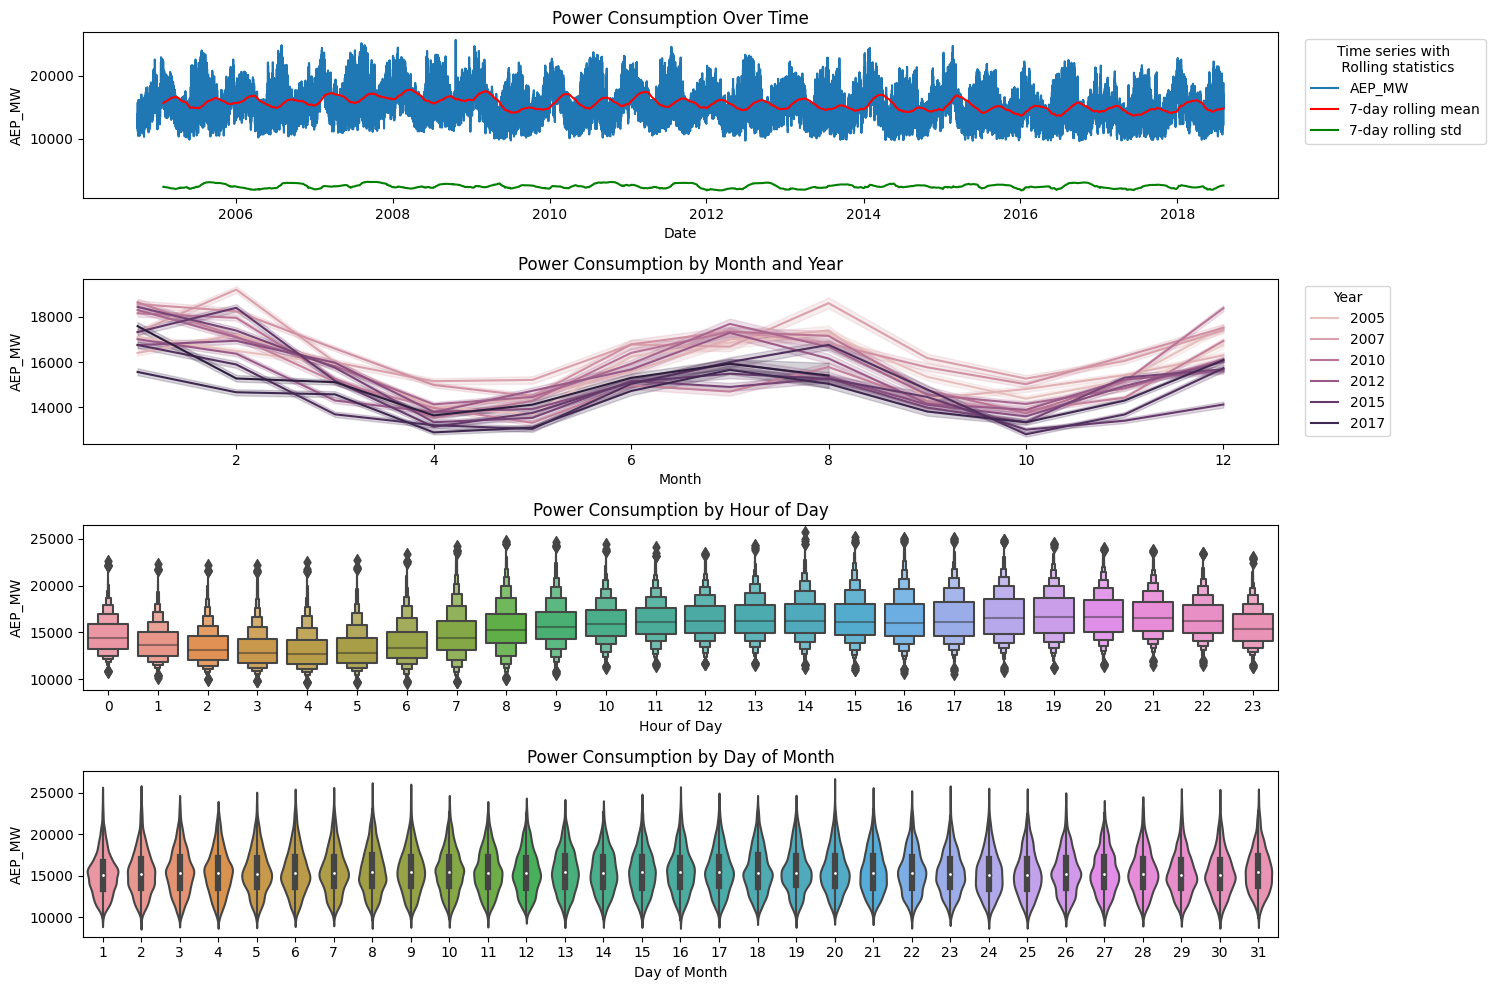

In [13]:
fig, axs = plt.subplots(4, 1, figsize=(15, 10))

# 1. Power consumption over time with rolling statistics
# Create rolling statistics
days = 120 # Number of days for the rolling window
rolling_window = 24*days  
rolling_mean = henergy_df['AEP_MW'].rolling(rolling_window).mean()
rolling_std = henergy_df['AEP_MW'].rolling(rolling_window).std()
dates = henergy_df.index  # full datetime, avoids duplicates
#plot the time series and rolling statistics
sns.lineplot(x=dates, y=henergy_df['AEP_MW'], ax=axs[0], label='AEP_MW')
sns.lineplot(x=dates, y=rolling_mean, ax=axs[0], color='red', label='7-day rolling mean')
sns.lineplot(x=dates, y=rolling_std, ax=axs[0], color='green', label='7-day rolling std')
axs[0].set_title("Power Consumption and Rolling Statistics")
axs[0].legend(title='Time series with \n Rolling statistics', bbox_to_anchor=(1.18, 1), loc='upper right')
axs[0].set_title('Power Consumption Over Time')
axs[0].set_xlabel('Date')

# 2. Power consumption by month and year to see seasonal trends
sns.lineplot(henergy_df, y='AEP_MW', x = 'Month', hue='Year', ax=axs[1])
axs[1].set_title('Power Consumption by Month and Year')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('AEP_MW')
axs[1].legend(title='Year', bbox_to_anchor=(1.1, 1), loc='upper right')
# 3. Power consumption by hour of day to see daily trends
sns.boxenplot(henergy_df, y='AEP_MW', x = 'Hour', ax=axs[2])
axs[2].set_title('Power Consumption by Hour of Day')
axs[2].set_xlabel('Hour of Day')
# 4. Power consumption by day of month to see monthly trends
sns.violinplot(henergy_df, y='AEP_MW', x = 'Day', ax=axs[3])
axs[3].set_title('Power Consumption by Day of Month')
axs[3].set_xlabel('Day of Month')

plt.tight_layout()
plt.show()


Based on the visual inspection I can see a slight trend in the data, however is a small decrease in the energy consumption over the years. Nevertheless to check if the trend has some statistical significance I will use a statistical test. The Augmented Dickey-Fuller test is a common test to check for trend in time series data. 

years wont be used as feature of the model, nor the day of the month as they not play a significant role in the energy consumption, however the month and the hour of the day will be used as features of the model. 

ADF Statistic: -18.306039800385413
p-value: 2.2812839721932943e-30
Critical Value (1%): -3.4304039570988323
Critical Value (5%): -2.861563848238303
Critical Value (10%): -2.566782693574735
Reject the null hypothesis: The time series is stationary at 1% significance level.


Text(0.5, 0, 'Power Consumption (MW)')

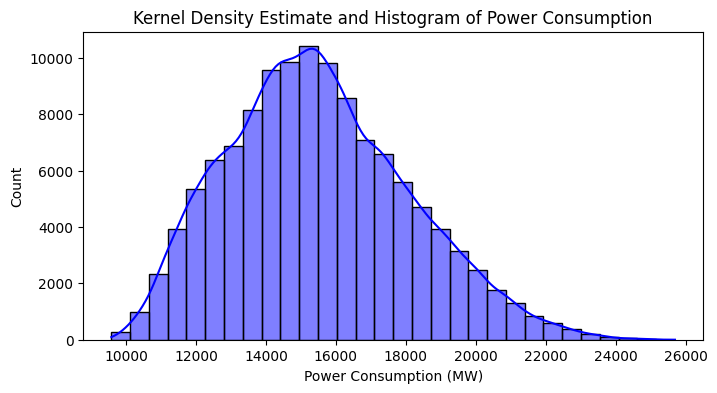

In [14]:

analyse_ADF_sstats(adfuller(henergy_df['AEP_MW'].values))

fig, ax = plt.subplots(figsize=(8, 4))
# 5. Kernel Density Estimate and Histogram of Power Consumption
sns.histplot(henergy_df['AEP_MW'], bins=30, kde=True, ax=ax, color='blue', label='Histogram')
ax.set_title('Kernel Density Estimate and Histogram of Power Consumption')
ax.set_xlabel('Power Consumption (MW)')



c:\Users\hecma\anaconda3\envs\PVproject\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


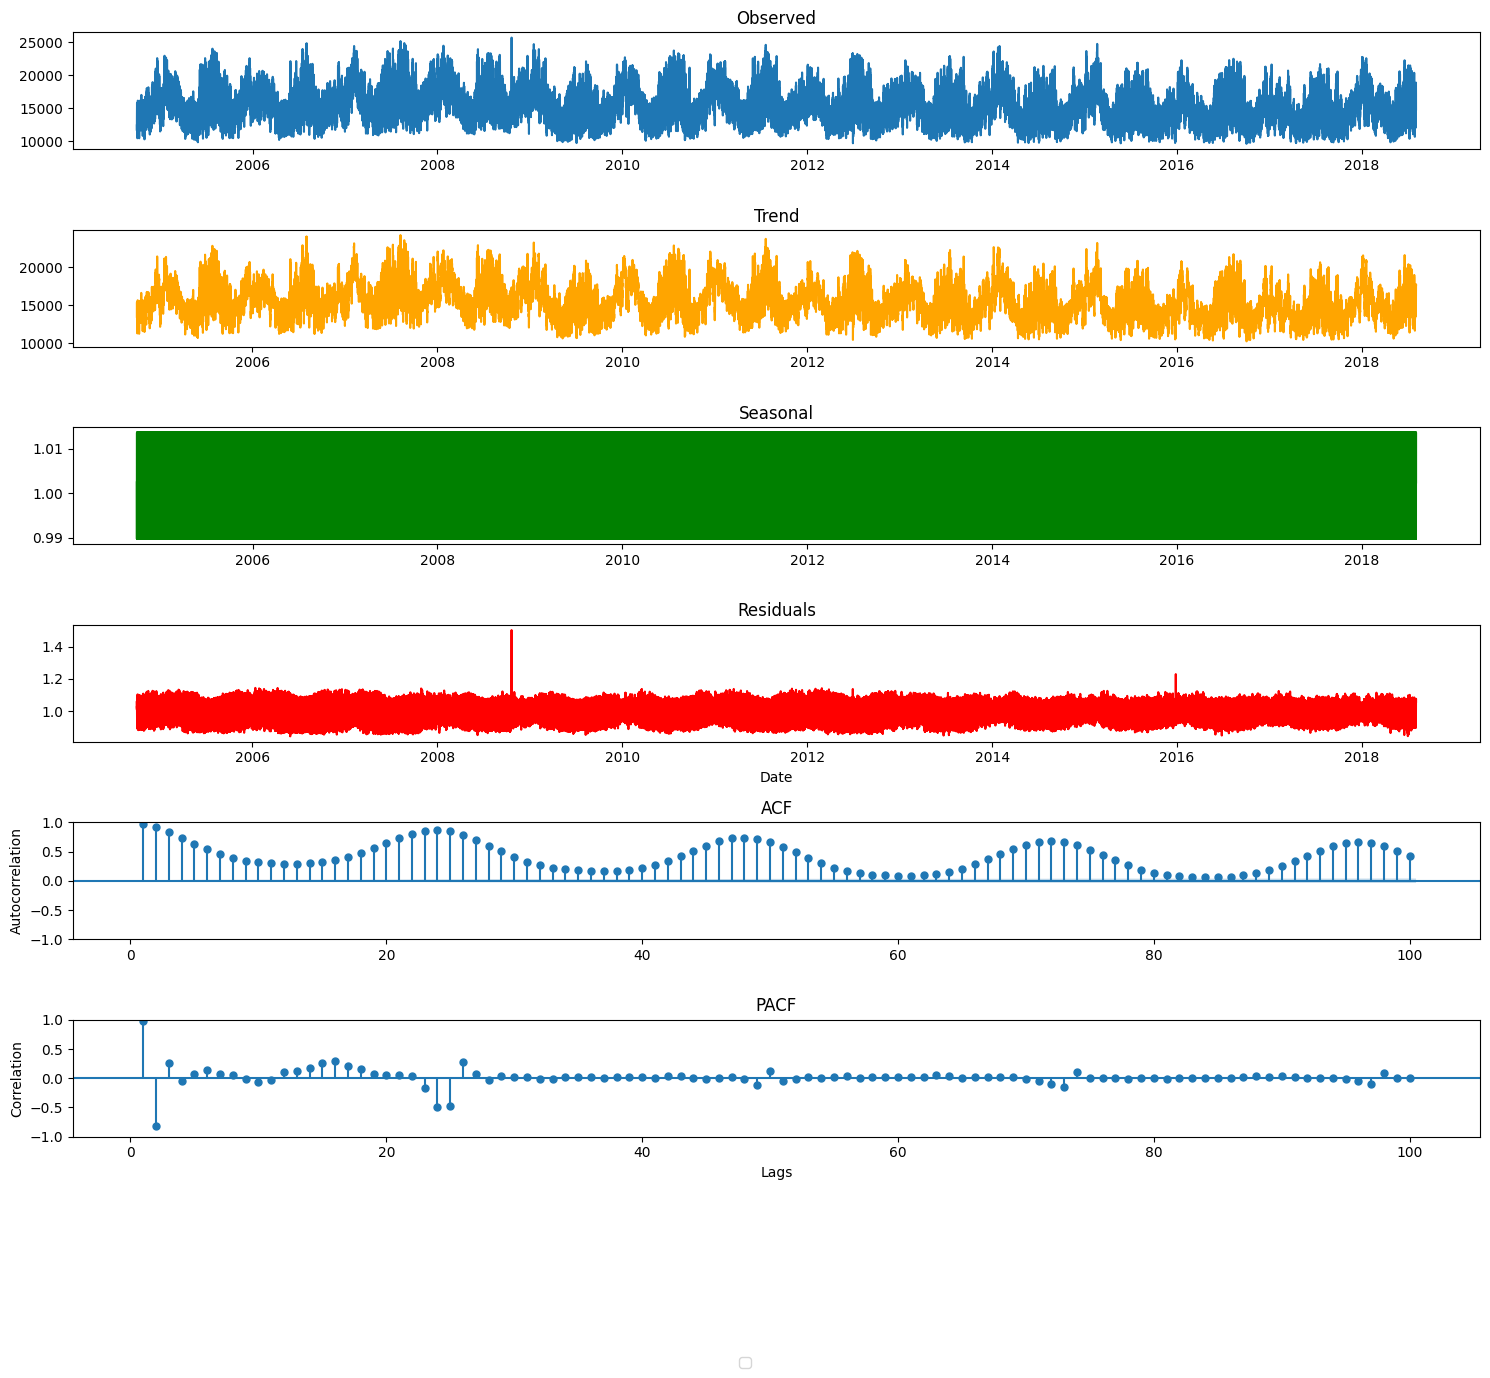

In [15]:

season_dec = seasonal_decompose(henergy_df_nprocessed['AEP_MW'], model='multiplicative', period=12)

# Plotting decomposition + ACF/PACF
fig, axs = plt.subplots(6, 1, figsize=(15, 12))

axs[0].plot(season_dec.observed)
axs[0].set_title('Observed')


axs[1].plot(season_dec.trend, color='orange')
axs[1].set_title('Trend')

axs[2].plot(season_dec.seasonal, color='green')
axs[2].set_title('Seasonal')

axs[3].plot(season_dec.resid, color='red')
axs[3].set_title('Residuals')
axs[3].set_xlabel('Date')

n_lags = 100
sm.graphics.tsa.plot_acf(henergy_df_nprocessed['AEP_MW'], lags=n_lags, ax=axs[4], title="ACF", zero=False)
sm.graphics.tsa.plot_pacf(henergy_df_nprocessed['AEP_MW'], lags=n_lags , ax=axs[5], title="PACF", zero=False)
axs[5].set_xlabel('Lags')
axs[4].set_ylabel('Autocorrelation')
axs[5].set_ylabel('Correlation')

fig.tight_layout()
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.15), ncol=4)

plt.show()

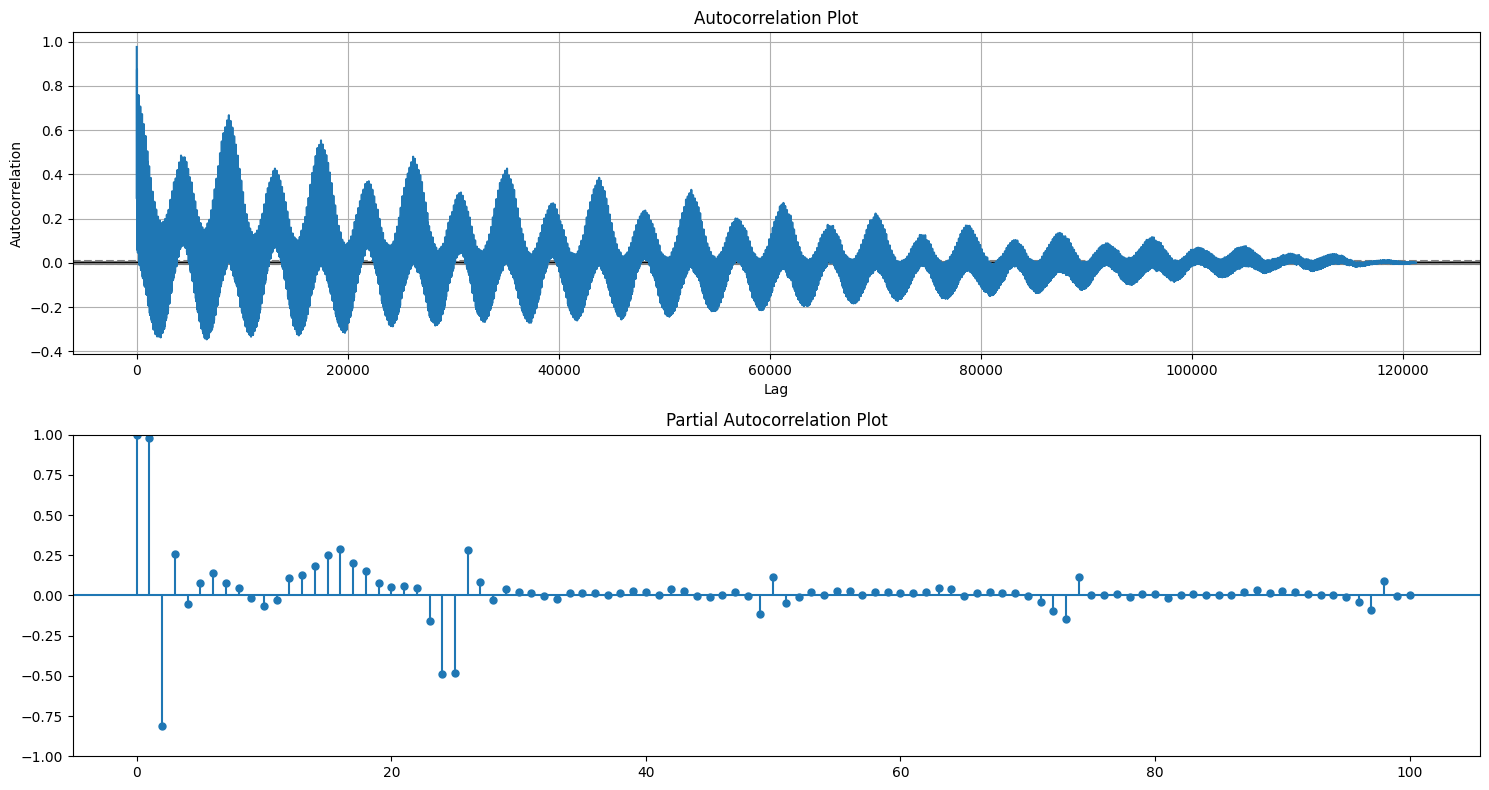

In [16]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_pacf

# Plot the ACF and PACF
fig, axs = plt.subplots(2, 1, figsize=(15, 8))
autocorrelation_plot(henergy_df_nprocessed['AEP_MW'],ax=axs[0]) # Plot the autocorrelation
plot_pacf(henergy_df_nprocessed['AEP_MW'], lags=100, ax=axs[1], method='ywm') # Plot first 20 lags
axs[0].set_title('Autocorrelation Plot')
axs[1].set_title('Partial Autocorrelation Plot')
plt.tight_layout()
plt.show()

## Feature engineering 

In [17]:
from statsmodels.tsa.stattools import pacf

pacf_values = pacf(henergy_df['AEP_MW'], nlags=100)  # Calculate PACF values up to 20 lags
print("Partial Autocorrelation Function (PACF) values:")
lag_df = pd.DataFrame({'Lag': range(len(pacf_values)), 'PACF': pacf_values})
lag_df.sort_values(by='PACF', inplace=True)

postive_lags = lag_df[0:5]
negative_lags = lag_df[-5:]

print("Positive Lags:")
print(postive_lags)
print("\nNegative Lags:")
print(negative_lags)
# I will use only the 10 most representative lags for the model


Partial Autocorrelation Function (PACF) values:
Positive Lags:
    Lag      PACF
2     2 -0.815108
24   24 -0.487746
25   25 -0.480714
23   23 -0.162363
73   73 -0.143658

Negative Lags:
    Lag      PACF
3     3  0.261749
26   26  0.284194
16   16  0.287115
1     1  0.976222
0     0  1.000000


In [18]:
lags_use = postive_lags['Lag'].tolist() + negative_lags['Lag'].tolist()
lags_use = [int(lag) for lag in lags_use]  # Convert to integers
lags_use = sorted(lags_use)[1:]  # Sort the lags
print("Lags to use in the model:", lags_use)

Lags to use in the model: [1, 2, 3, 16, 23, 24, 25, 26, 73]


In [19]:

for lag in lags_use:
    henergy_df[f'Lag{lag}'] = henergy_df['AEP_MW'].shift(lag)

henergy_df.head()

,Datetime,AEP_MW,Year,Month,Day,Hour,Lag1,Lag2,Lag3,Lag16,Lag23,Lag24,Lag25,Lag26,Lag73
Datetime,,,,,,,,,,,,,,,
2004-10-01 01:00:00,2004-10-01 01:00:00,12379.0,2004,10,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 02:00:00,2004-10-01 02:00:00,11935.0,2004,10,1,2,12379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 03:00:00,2004-10-01 03:00:00,11692.0,2004,10,1,3,11935.0,12379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 04:00:00,2004-10-01 04:00:00,11597.0,2004,10,1,4,11692.0,11935.0,12379.0,NaN,NaN,NaN,NaN,NaN,NaN
2004-10-01 05:00:00,2004-10-01 05:00:00,11681.0,2004,10,1,5,11597.0,11692.0,11935.0,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:

henergy_df.drop(columns=['Datetime','Year', 'Day'], inplace=True)  # Drop the original column to avoid redundancy
henergy_df.dropna(inplace=True)  # Drop rows with NaN values after shifting
henergy_df['Month'] = henergy_df['Month'].astype('category')  # Convert Month to categorical type
henergy_df['Hour'] = henergy_df['Hour'].astype('category')  # Convert Hour to categorical type
henergy_df.head()

,AEP_MW,Month,Hour,Lag1,Lag2,Lag3,Lag16,Lag23,Lag24,Lag25,Lag26,Lag73
Datetime,,,,,,,,,,,,
2004-10-04 02:00:00,11408.0,10,2,11817.0,12351.0,13132.0,12493.0,10600.0,10807.0,11443.0,12172.0,12379.0
2004-10-04 03:00:00,11261.0,10,3,11408.0,11817.0,12351.0,12722.0,10438.0,10600.0,10807.0,11443.0,11935.0
2004-10-04 04:00:00,11247.0,10,4,11261.0,11408.0,11817.0,12908.0,10430.0,10438.0,10600.0,10807.0,11692.0
2004-10-04 05:00:00,11414.0,10,5,11247.0,11261.0,11408.0,12997.0,10509.0,10430.0,10438.0,10600.0,11597.0
2004-10-04 06:00:00,12283.0,10,6,11414.0,11247.0,11261.0,12924.0,10795.0,10509.0,10430.0,10438.0,11681.0


### Cross validation
I will spit the time series data. this is done differntly to a normal set where the data can be split normally. 
Time split splits the data into training and test sets based on time. The training set is the first part of the data and the test set is the last part of the data. This is done to ensure that the model is trained on past data and tested on future data.`

For this I will do a similiar split to [TimeSeriesSplit](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-of-time-series-data) from sklearn.

In [21]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
X = henergy_df.drop(columns=['AEP_MW'])
y = henergy_df['AEP_MW']
X_train, X_test, y_train, y_test = [], [], [], []
for train_index, test_index in tscv.split(henergy_df):
    X_train.append(X.iloc[train_index])
    X_test.append(X.iloc[test_index])
    y_train.append(y.iloc[train_index])
    y_test.append(y.iloc[test_index])  
     
print(f"Number of splits: {n_splits}")
print(f"Number of training sets: {len(X_train)}")
    
    

Number of splits: 5
Number of training sets: 5


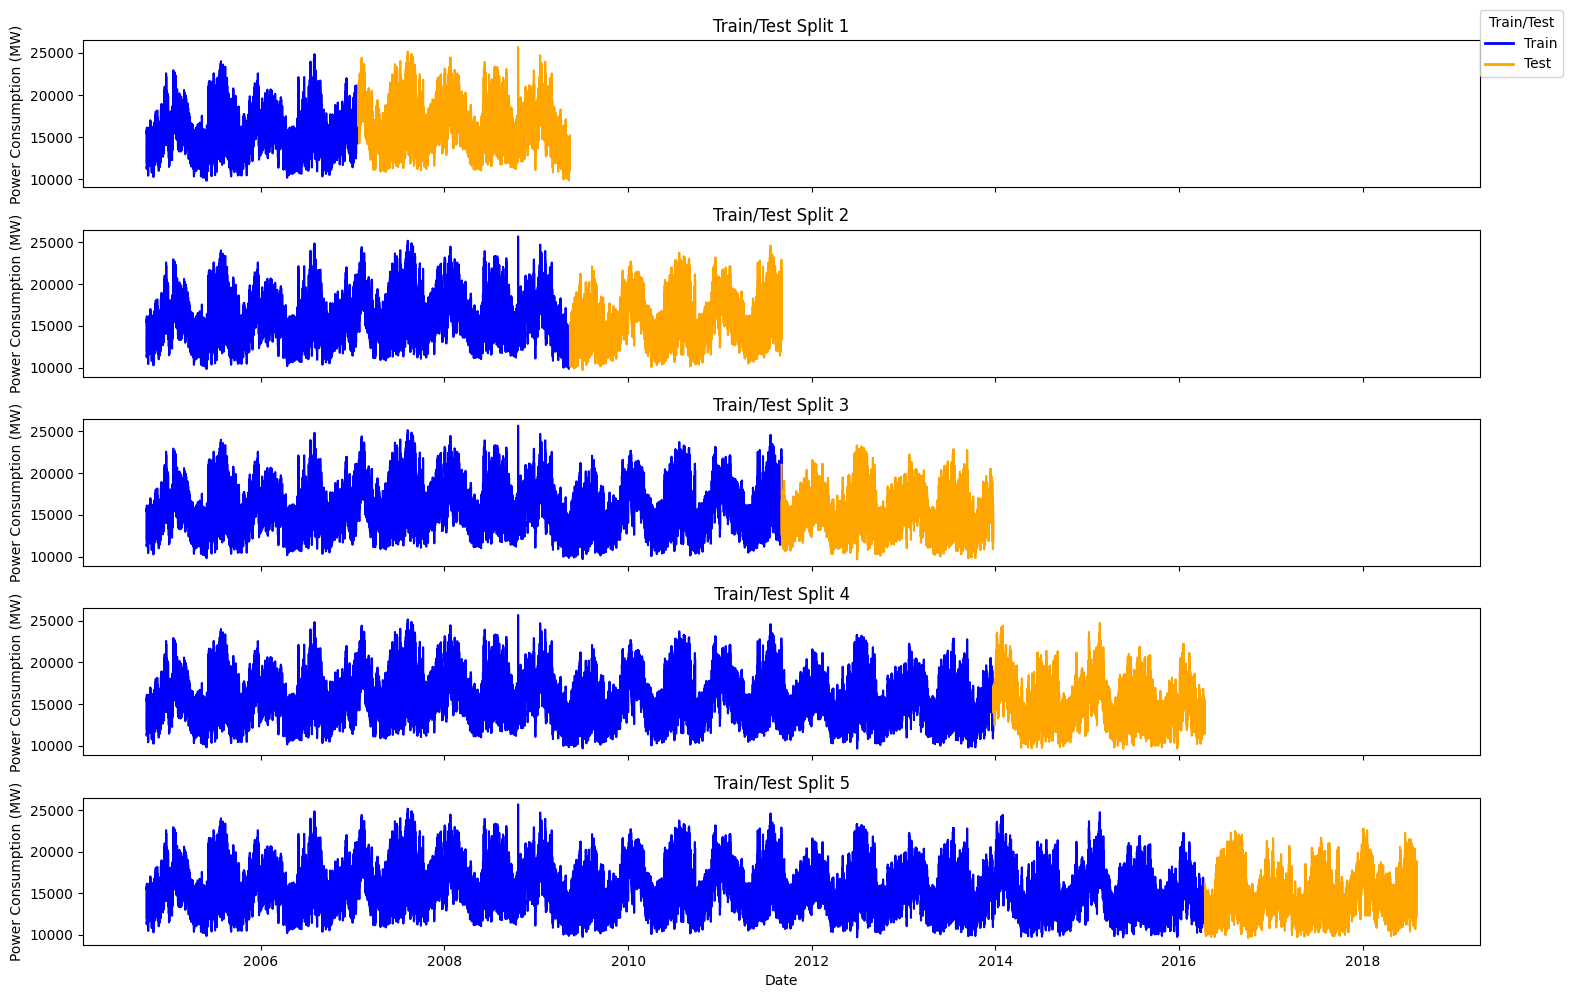

In [22]:
#plot the training and test sets
fig, axs = plt.subplots(n_splits, 1, figsize=(15, 10), sharex=True)
for i in range(n_splits):
    axs[i].plot(X_train[i].index, y_train[i], label='Train', color='blue')
    axs[i].plot(X_test[i].index, y_test[i], label='Test', color='orange')
    axs[i].set_title(f'Train/Test Split {i+1}')
    axs[i].set_ylabel('Power Consumption (MW)')
    
fig.legend(loc='upper right', bbox_to_anchor=(1.05, 1), title='Train/Test', handles=[
    plt.Line2D([0], [0], color='blue', lw=2, label='Train'),
    plt.Line2D([0], [0], color='orange', lw=2, label='Test')])
plt.xlabel('Date')

plt.tight_layout()
plt.show()

# Train the model and fine tune the hyperparameters


In [23]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


# Define XGBRegressor
# In this case I will use a GPU-accelerated version of XGBoost for faster training, as I have an available GPU. 
xgb_model = xgb.XGBRegressor(
    tree_method="hist", 
    device="cuda",
    random_state=42, 
    enable_categorical=True) 

# Define hyperparameter grid
param_grid = {
    'n_estimators': [200, 250, 300],  # Number of trees
    'max_depth': [ 5, 7, 9],  # Maximum depth of a tree
    'learning_rate': [0.1, 0.2, 0.05],  # Step size shrinkage
    'gamma': [0, 0.1, 0.2],  # Minimum loss reduction required to make a further partition
    }

# GridSearchCV (e.g., with TimeSeriesSplit stored in `tscv`)
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=tscv, n_jobs=-1)



def Train_and_test(X_train, y_train, X_test, y_test, k_fold, grid_search):
    """This function trains the model and tests it on the test set."""
    # Fit
    grid_search.fit(X_train[k_fold], y_train[k_fold])  # Use DataFrame directly

    # Best model & prediction
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test[k_fold])

    # Evaluation
    mse = mean_squared_error(y_test[k_fold], y_pred)
    r2 = r2_score(y_test[k_fold], y_pred)
    print("Best Hyperparameters:", grid_search.best_params_)
    print(f"Root Mean Squared Error: {np.sqrt(mse)}")
    print(f"R-squared: {r2}")

    # Plot
    plt.figure(figsize=(15, 5))
    plt.plot(y_test[k_fold].index, y_test[k_fold], label='True data', color='blue')
    plt.plot(y_test[k_fold].index, y_pred, label='Predicted data', color='red', alpha=0.7)
    plt.title('XGBoost Predictions vs Actual Values')
    plt.legend(title='Data', bbox_to_anchor=(1.1, 1), loc='upper right')
    plt.xlabel('Date')
    plt.ylabel('Power Consumption (MW)')
    plt.xticks(rotation=45)
    plt.show()
    
    return best_model, y_pred, grid_search.best_params_

    


[19:27:29] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Root Mean Squared Error: 218.84295614299282
R-squared: 0.9931633903785221


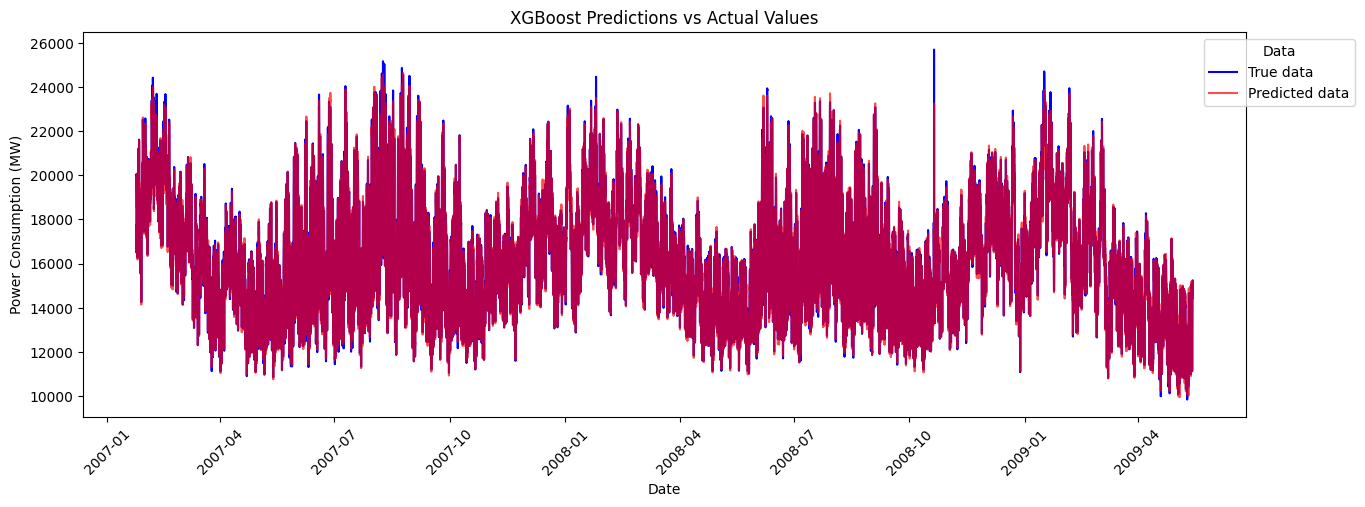

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...),
 array([17680.059, 16945.629, 16738.895, ..., 15103.748, 14830.57 ,
        14485.786], dtype=float32),
 {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300})

In [24]:
# Train and test the model
Train_and_test(X_train, y_train, X_test, y_test, 0 , grid_search)

[19:28:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Root Mean Squared Error: 158.33243211712298
R-squared: 0.9964887245346811


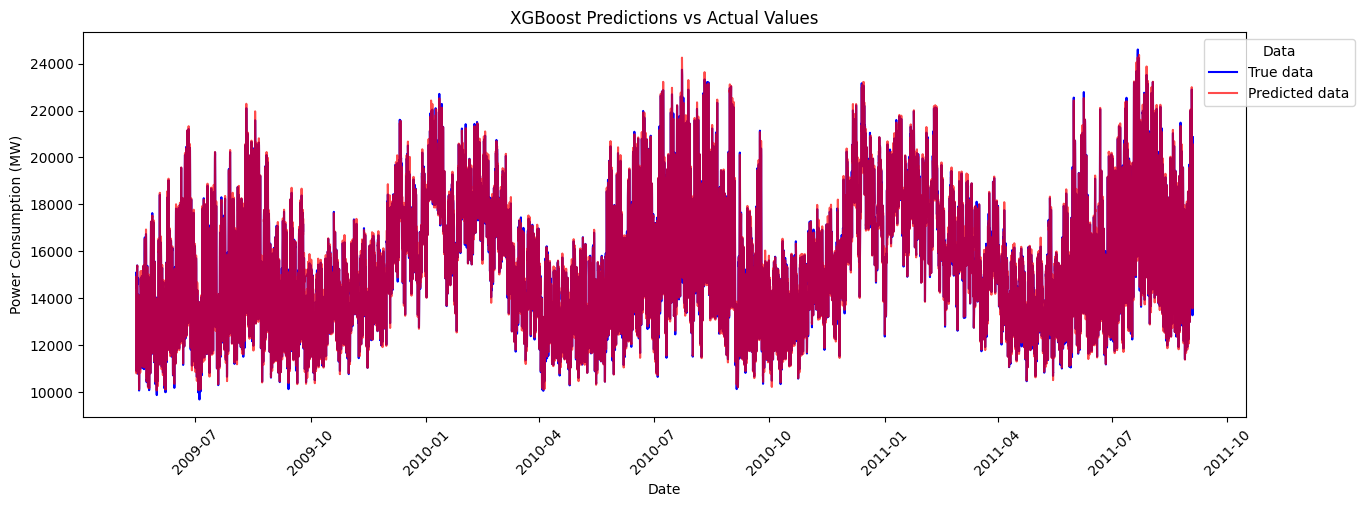

[19:30:24] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0.2, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 155.2231544082553
R-squared: 0.9955828654305043


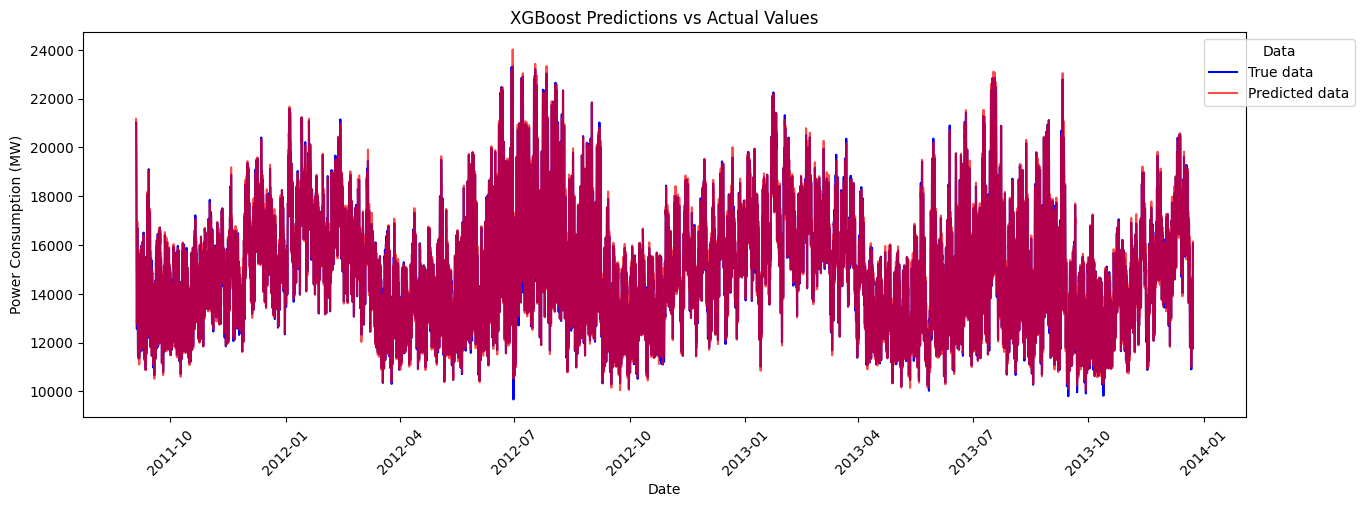

[19:32:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 156.21472071054131
R-squared: 0.9962845612388697


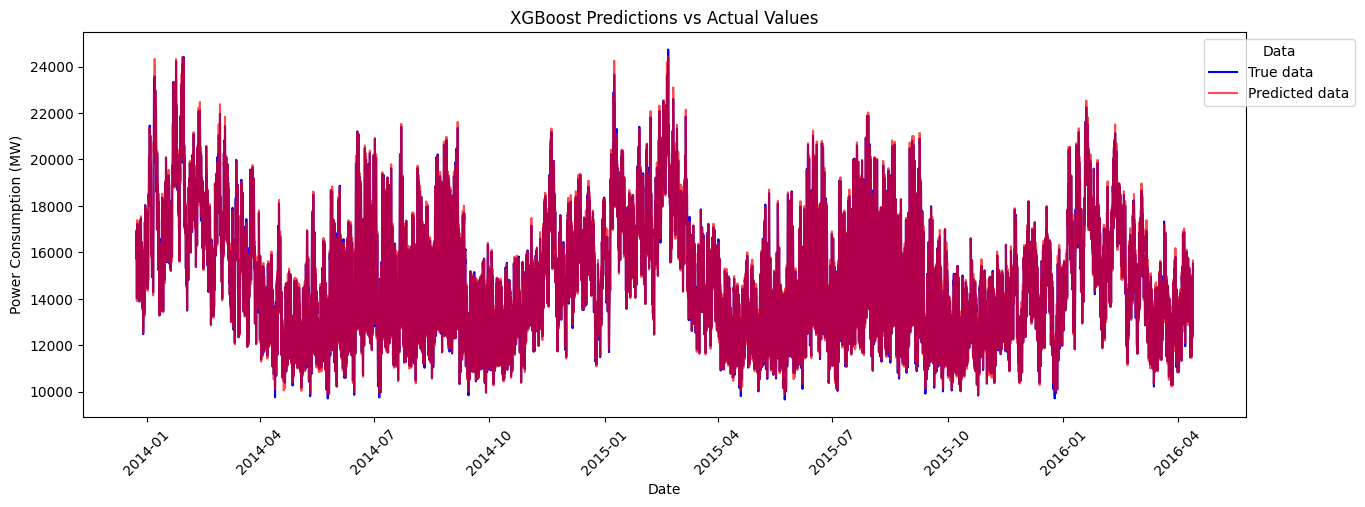

[19:34:28] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


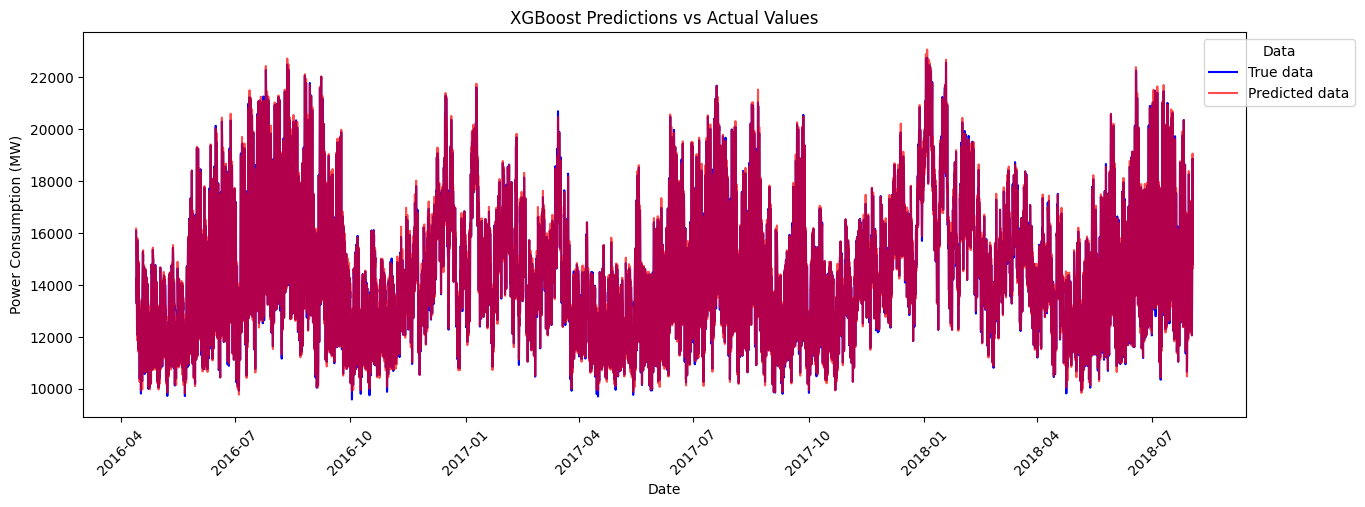

(XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=True, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=300, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...),
 array([16165.748, 16016.043, 15334.889, ..., 16929.895, 15831.324,
        14641.921], dtype=float32),
 {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300})

In [25]:
Train_and_test(X_train, y_train, X_test, y_test, 1 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 2 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 3 , grid_search)
Train_and_test(X_train, y_train, X_test, y_test, 4 , grid_search)
# Train and test the model with the best hyperparameters

Use the model with the best hyperparameters to train the model on the training set.

[19:36:39] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


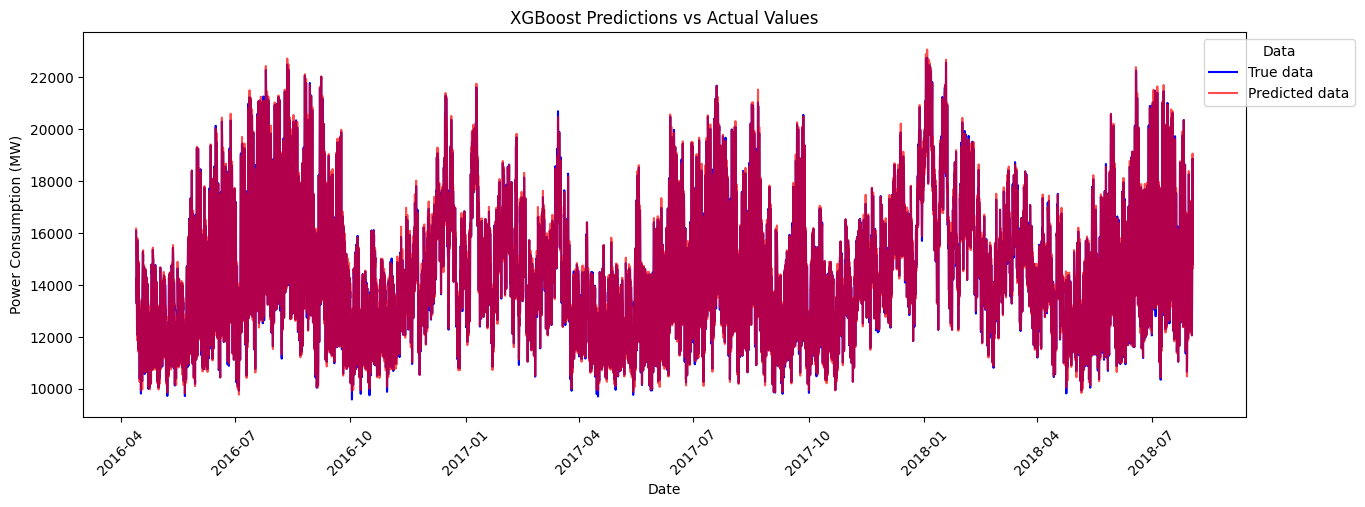

In [26]:
best_model, y_pred, best_params = Train_and_test(X_train, y_train, X_test, y_test, 4 , grid_search) 


[19:36:40] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "device" } are not used.

Best Hyperparameters: {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300}
Root Mean Squared Error: 144.84495662543023
R-squared: 0.9966192345602718


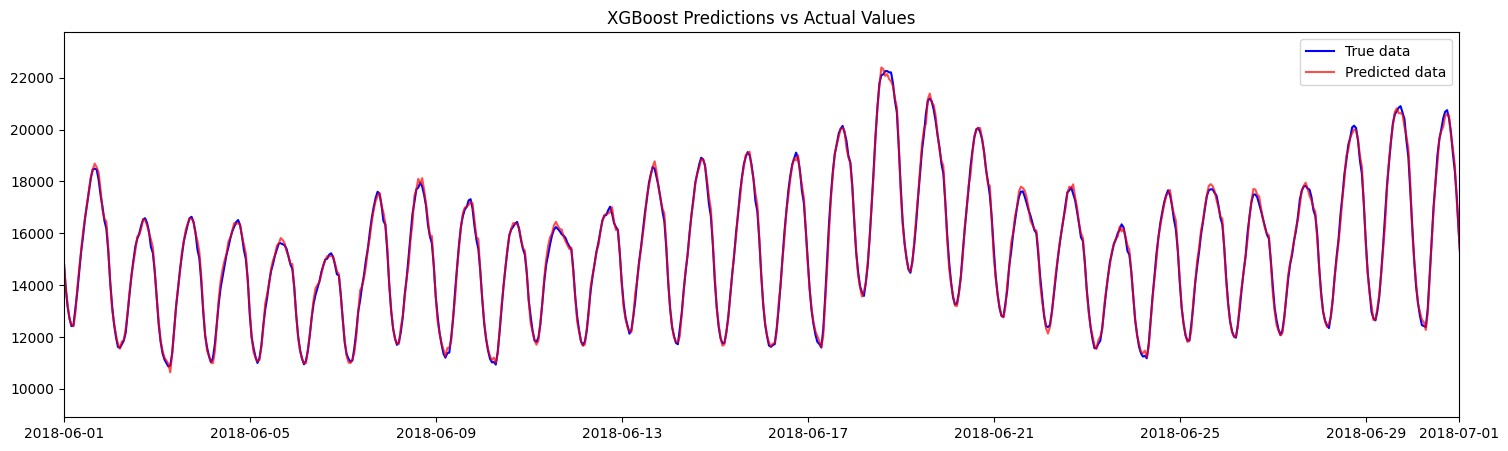

In [27]:
xgb_model = xgb.XGBRegressor(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    gamma=best_params['gamma'],
    tree_method="hist",
    enable_categorical=True,
    device="cuda")
# Fit the model on the entire training set
xgb_model.fit(X_train[4], y_train[4])
# Make predictions on the test set
y_pred = xgb_model.predict(X_test[4])
# Evaluate the model
mse = mean_squared_error(y_test[4], y_pred)
r2 = r2_score(y_test[4], y_pred)
print("Best Hyperparameters:", best_params)
print(f"Root Mean Squared Error: {np.sqrt(mse)}")
print(f"R-squared: {r2}")
# Plot the predictions vs actual values
fig, ax = plt.subplots(figsize=(18, 5))
ax.plot(y_test[4].index, y_test[4], label='True data', color='blue')
ax.plot(y_test[4].index, y_pred, label='Predicted data', color='red', alpha=0.7)
ax.set_xlim(pd.to_datetime('2018-06-01'), pd.to_datetime('2018-07-01'))
ax.set_title('XGBoost Predictions vs Actual Values')
ax.legend()
plt.show()


In [ ]:
#Save the model to a file to use it later
xgb_model.save_model("../saved_models/xgb_energy_model.json")
